<a href="https://colab.research.google.com/github/jungbok/CNN_Image_Colorization/blob/master/lab6_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNNs for Image Colorization
JungBok Lee
6896785721


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
# import cv2
from matplotlib.colors import to_hex
from skimage.color import rgb2gray
from skimage.color import rgb2grey

a) Download the CIFAR-10 dataset

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
images before normalization: 


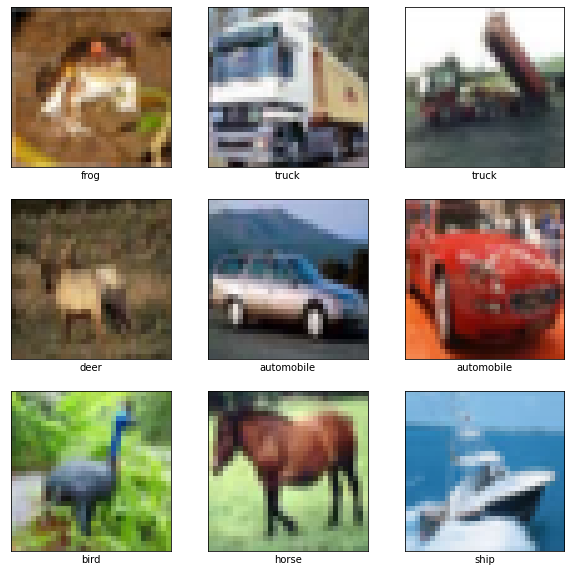

images after normalization: 


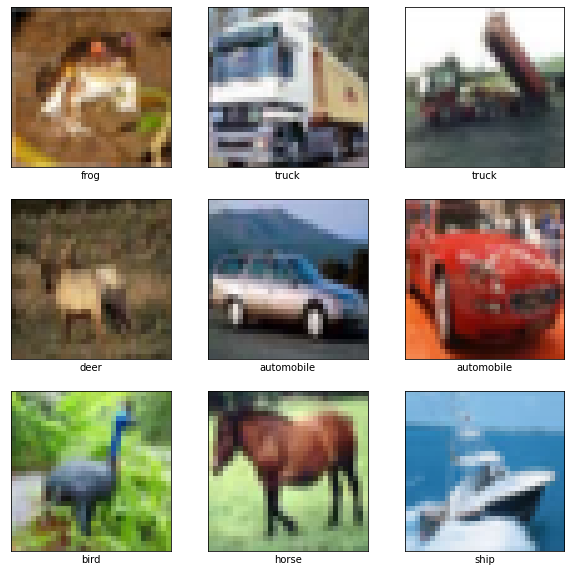

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1 - Necessary?
# train_images, test_images = train_images / 255.0, test_images / 255.0

# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))

# Normalized images
nol_train_images, nol_test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# plot 9 images function
def plot9Images(images, labels):
  plt.figure(figsize=(10,10))
  for i in range(9):
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      # The CIFAR labels happen to be arrays, 
      # which is why you need the extra index
      plt.xlabel(class_names[labels[i][0]])
  plt.show()

print("images before normalization: ")
plot9Images(train_images, train_labels)
print("images after normalization: ")
plot9Images(nol_train_images, train_labels)

b) From the train and test dataset, extract the class birds

Train Index Shape for the class Bird: (50000,)
Test Index Shape for the class Bird: (10000,)
Train dataset labelled as bird


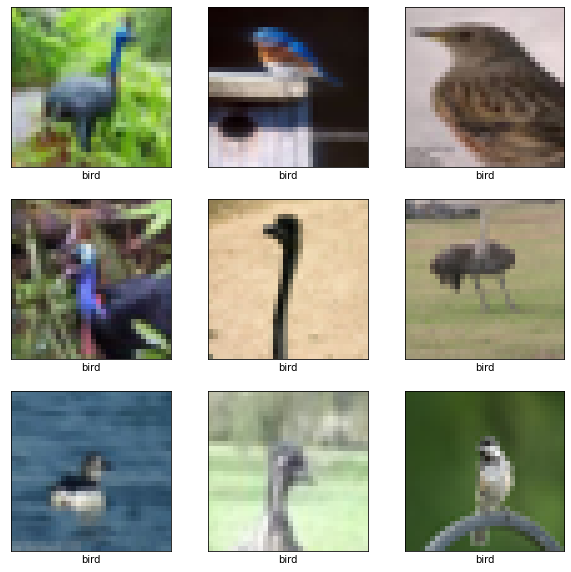

Test dataset labelled as bird


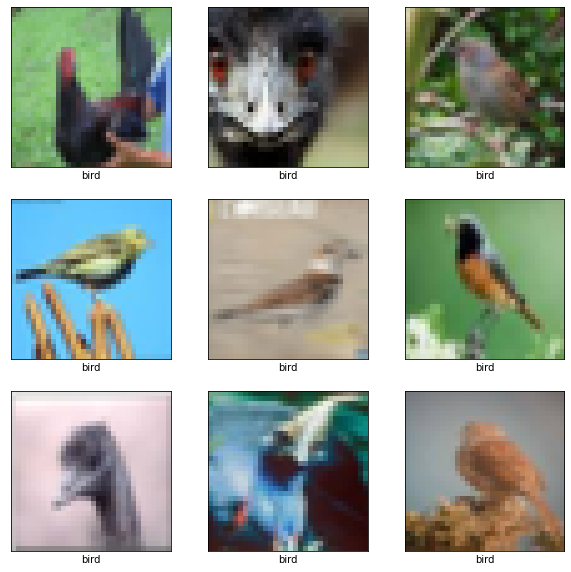

In [3]:
# currently using normalized data
idx = (train_labels == 2).reshape(train_images.shape[0])
print('Train Index Shape for the class Bird: {}'.format(idx.shape))
bird_train_images = nol_train_images[idx]
bird_train_labels = train_labels[idx]

t_idx = (test_labels == 2).reshape(test_images.shape[0])
print('Test Index Shape for the class Bird: {}'.format(t_idx.shape))
bird_test_images = nol_test_images[t_idx]
bird_test_labels = test_labels[t_idx]

print("Train dataset labelled as bird")
plot9Images(bird_train_images, bird_train_labels)
print("Test dataset labelled as bird")
plot9Images(bird_test_images, bird_test_labels)


# currently not using normalized data
#idxc = (train_labels == 3).reshape(train_images.shape[0])
#print('Train Index Shape for the class Bird: {}'.format(idxc.shape))
#cat_train_images = train_images[idxc]
#cat_train_labels = train_labels[idxc]
#plot9Images(cat_train_images, cat_train_labels)

c) Images have 6000 X 32 X 32 pixels: choose at least 10% of the pixels randomly. P = 614400 and P = 6144000 pixels

In [4]:
row = np.random.randint(32, size=None)
col = np.random.randint(32)
image = np.random.randint(6000)

# random 80% of the pixel -> 6144000 * 0.8 =. 4915200
randPix = np.random.randint([32, 32, 600], size=(6144000,1,3))
print(randPix.shape)
# print(randPix[:10, 0, 1])

bird_images = np.concatenate([bird_train_images, bird_test_images])
print("bird_images(train, test combined) shape: ", bird_images.shape)
rsbirds = bird_images[randPix[:,0,2], randPix[:,0,1], randPix[:,0,0], :]

print("RGB of pixel chosen")
print(rsbirds[:3])

(6144000, 1, 3)
bird_images(train, test combined) shape:  (6000, 32, 32, 3)
RGB of pixel chosen
[[0.14901961 0.19607843 0.25490196]
 [0.21176471 0.21568627 0.16078431]
 [0.79607843 0.81176471 0.81176471]]


d) Run k-means clustering on the P vectors using K = 4

In [5]:
rsbirdsAll = bird_images.reshape(6144000, 3)
print(rsbirdsAll[:3, :])
kmeans = KMeans(n_clusters=4, init='random', random_state=None).fit(rsbirdsAll)
# clusters = kmeans.fit_predict(rsbirds)
# print(clusters.shape)
print(kmeans.labels_)
# print(kmeans.shape)
palette = kmeans.cluster_centers_

[[0.64313725 0.80784314 0.32941176]
 [0.41176471 0.54901961 0.23921569]
 [0.4627451  0.58039216 0.39607843]]
[2 1 1 ... 2 2 2]


Palette RGB val:  [[0.19162828 0.19546073 0.1506801 ]
 [0.42590847 0.42472016 0.3235777 ]
 [0.61190614 0.60882319 0.52941267]
 [0.80847017 0.82925647 0.82804924]]
#313226


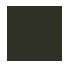

#6d6c53


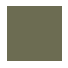

#9c9b87


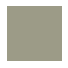

#ced3d3


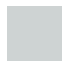

In [6]:
print("Palette RGB val: ", palette)
palette_list = list()
for color in palette:
    palette_list.append([[tuple(color)]])

# Show color palette
for color in palette_list:
    print(to_hex(color[0][0]))
    plt.figure(figsize=(1, 1))
    plt.axis('off')
    plt.imshow(color);
    plt.show();
#palette.reshape(())

e) Obtain Grayscale images from the origianl images

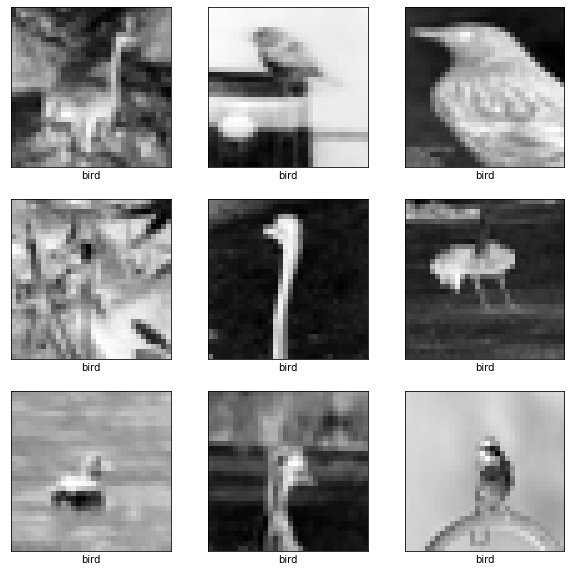

In [7]:
# using skimage
# RGB2GRAY
gray_bird_image = []

for i in range(bird_images.shape[0]):
    gray_bird_image.append(rgb2grey(bird_images[i]))
gray_bird_image = np.asarray(gray_bird_image)
gray_bird_image_cp = gray_bird_image[5000:5010]
plot9Images(gray_bird_image, bird_train_labels)

f) Deep Convolutional Neural Network with two convolutional layers and two MLP layers

In [8]:
# using 5*5 filters and a softmax output layer
gray_bird_image = gray_bird_image.reshape((6000, 32, 32, 1))
print(gray_bird_image.shape)
train_gray_bird = gray_bird_image[:5000]
test_gray_bird = gray_bird_image[5000:]

print(train_gray_bird[0, 0, 0])
print(test_gray_bird.shape[0])

def make_cnn_model(image_size, class_size = 4, extra_layer=0):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
  #model.add(layers.MaxPooling2D((2, 2)))
  # Extra Layers

  # reshaping the output - 4 default class for k=4
  model.add(layers.Flatten())
  model.add(layers.Dense(8192, activation='relu'))
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Reshape((32,32,4)))
  model.add(layers.Softmax())
  #model.add(layers.Dense(32, activation='relu'))
  
  #model.add(layers.Dense(class_size))

  model.summary()

  return model


(6000, 32, 32, 1)
[0.73834824]
1000


In [9]:
model = make_cnn_model(32, class_size=4)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8192)              16785408  
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 4)         0

In [10]:
k4_hot_encoding = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
# y_train = tf.constant(y_train, shape=[4, 4])
print(kmeans.labels_)
# print(kmeans.shape)
y_train = []
for i in range(len(kmeans.labels_)):
  if kmeans.labels_[i] == 0:
    y_train.append(k4_hot_encoding[0])
  elif kmeans.labels_[i] == 1:
      y_train.append(k4_hot_encoding[1])
  elif kmeans.labels_[i] == 2:
      y_train.append(k4_hot_encoding[2])
  else:
      y_train.append(k4_hot_encoding[3])


[2 1 1 ... 2 2 2]


In [11]:
#print(y_train.shape)
y_encoded = np.array(y_train)

y_encoded = y_encoded.reshape((-1,32, 32, 4))
y_encoded =np.array(y_encoded)
print(y_encoded.shape)
#print()

(6000, 32, 32, 4)


In [12]:
# compile and train
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gray_bird, y_encoded[:5000], epochs=30, 
                    validation_data=(test_gray_bird, y_encoded[5000:]))

Epoch 1/30
157/157 [==============================] - 82s 518ms/step - loss: 1.3492 - accuracy: 0.3074 - val_loss: 1.1984 - val_accuracy: 0.4012
Epoch 2/30
157/157 [==============================] - 81s 518ms/step - loss: 1.1654 - accuracy: 0.4189 - val_loss: 1.1069 - val_accuracy: 0.4446
Epoch 3/30
157/157 [==============================] - 83s 530ms/step - loss: 1.0952 - accuracy: 0.4486 - val_loss: 1.0776 - val_accuracy: 0.4613
Epoch 4/30
157/157 [==============================] - 81s 513ms/step - loss: 1.0496 - accuracy: 0.4734 - val_loss: 1.0559 - val_accuracy: 0.4700
Epoch 5/30
157/157 [==============================] - 81s 519ms/step - loss: 1.0175 - accuracy: 0.4883 - val_loss: 1.0334 - val_accuracy: 0.4790
Epoch 6/30
157/157 [==============================] - 81s 518ms/step - loss: 0.9758 - accuracy: 0.5071 - val_loss: 1.0181 - val_accuracy: 0.4917
Epoch 7/30
157/157 [==============================] - 81s 518ms/step - loss: 0.9420 - accuracy: 0.5246 - val_loss: 0.9935 - val_ac

32/32 [==============================] - 2s 73ms/step - loss: 1.9666 - accuracy: 0.5215
(1000, 32, 32, 4)


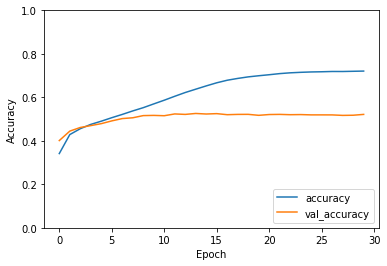

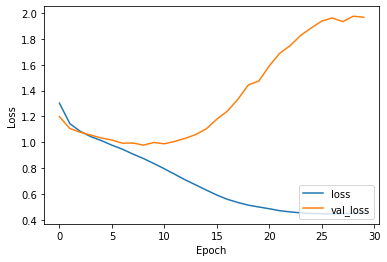

Test_result: 
test accuracy:  0.521530270576477
test loss:  1.9666106700897217


In [13]:
# print(history.history)
# change y_encoded to actual/original image? 
test_loss, test_acc = model.evaluate(test_gray_bird, y_encoded[5000:], verbose=1)
# predict
pred_test = model.predict(test_gray_bird)
print(pred_test.shape)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# prediction[i] = clusters_center_[prediction[i]]
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

print("Test_result: ")
print("test accuracy: ", test_acc)
print("test loss: ", test_loss)

p_t_shape:  (1000, 1024, 4)
K_color_pixels (1000, 32, 32, 3)


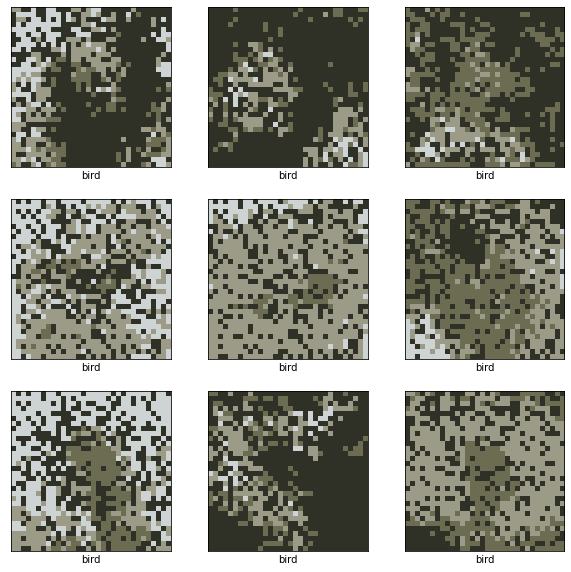

In [14]:
pred_test = pred_test.reshape((-1, 1024, 4))
print("p_t_shape: ", pred_test.shape)
# argmax returns the indices of the maximum value along an axis
pred_labels = np.argmax(pred_test, axis=2)
# print("pred_labels: ", pred_labels[:10])
k_color_pixels = []
for x in pred_labels:
  k_color_pixels.append(kmeans.cluster_centers_[x])
k_color_pixels = np.array(k_color_pixels)
k_color_pixels = k_color_pixels.reshape((1000, 32, 32,3))
print("K_color_pixels", k_color_pixels.shape)
# print(k_color_pixels[:3])
plot9Images(k_color_pixels, bird_test_labels)

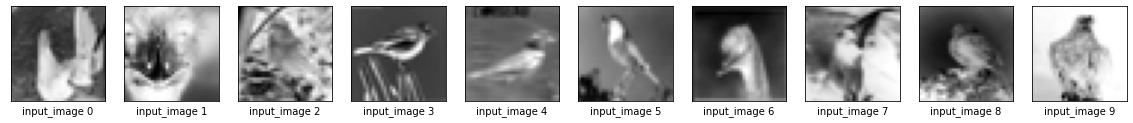

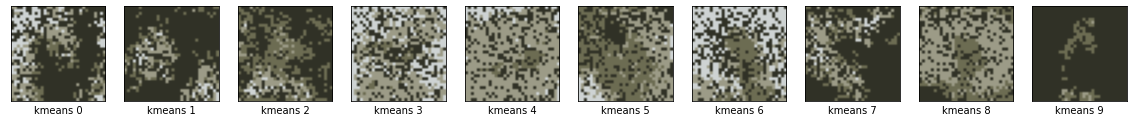

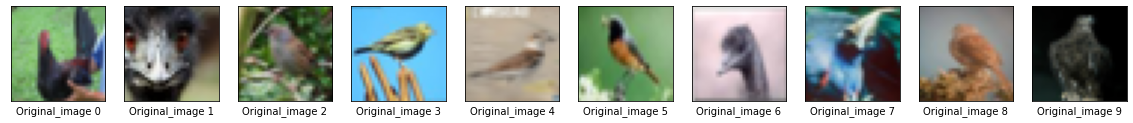

In [15]:
def plot10Images(images, gray_images, og_images, labels):
  plt.figure(figsize=(20,20))
  for j in range(10):
      plt.subplot(1, 10, j+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(gray_images[j], cmap=plt.cm.binary)
      plt.xlabel("input_image " + str(labels[j]))
  plt.show()

  plt.figure(figsize=(20,20))
  for i in range(10):
      plt.subplot(1, 10, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel("kmeans " + str(labels[i]))
  plt.show()


  plt.figure(figsize=(20,20))
  for k in range(10):
      plt.subplot(1, 10, k+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(og_images[k], cmap=plt.cm.binary)
      plt.xlabel("Original_image " + str(labels[k]))
  plt.show()

numbers = []
for i in range(10):
  numbers.append(i)
plot10Images(k_color_pixels, gray_bird_image_cp, bird_test_images, numbers)

g) k = 8, 16, 32

In [16]:
def kmeansN(k):
  rsbirdsAll = bird_images.reshape(6144000, 3)
  kmeans = KMeans(n_clusters=k, init='random', random_state=None, n_jobs=-1).fit(rsbirdsAll)
  print(kmeans.labels_)
  # print(kmeans.shape)
  palette = kmeans.cluster_centers_
  print("Palette RGB val: ", palette)
  palette_list = list()
  for color in palette:
      palette_list.append([[tuple(color)]])

  # Show color palette
  for color in palette_list:
      print(to_hex(color[0][0]))
      plt.figure(figsize=(1, 1))
      plt.axis('off')
      plt.imshow(color);
      plt.show();
  
  return palette, kmeans.labels_

[4 3 2 ... 2 2 2]
Palette RGB val:  [[0.1188746  0.1221946  0.09699833]
 [0.92076913 0.92588485 0.91381265]
 [0.55793468 0.53821246 0.40325475]
 [0.42011368 0.41621665 0.31268974]
 [0.68818732 0.65664128 0.54301043]
 [0.27883233 0.28246337 0.21480213]
 [0.73249975 0.76192707 0.77246457]
 [0.40293478 0.54739524 0.69800116]]
#1e1f19


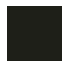

#ebece9


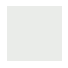

#8e8967


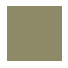

#6b6a50


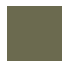

#afa78a


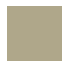

#474837


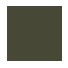

#bbc2c5


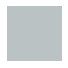

#678cb2


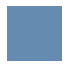

(6144000,)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[ 5 10 13 ...  1  1  1]
Palette RGB val:  [[0.50813192 0.39822462 0.26619372]
 [0.61047867 0.5729134  0.35843485]
 [0.36981498 0.38202215 0.34943399]
 [0.31168087 0.3087829  0.21982708]
 [0.0818603  0.08465277 0.06798866]
 [0.75669285 0.68793477 0.46853688]
 [0.25123027 0.43211831 0.62625153]
 [0.70289658 0.69781636 0.66126714]
 [0.46456812 0.62100501 0.79172195]
 [0.19954966 0.2054708  0.16196608]
 [0.43650923 0.52187053 0.23835571]
 [0.94433729 0.94929059 0.94299351]
 [0.83930712 0.81657227 0.758327  ]
 [0.48455614 0.48537018 0.44242193]
 [0.67499519 0.78725312 0.89457791]
 [0.59228825 0.58973334 0.54592772]]
#826644


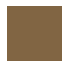

#9c925b


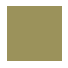

#5e6159


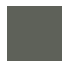

#4f4f38


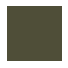

#151611


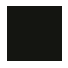

#c1af77


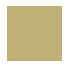

#406ea0


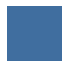

#b3b2a9


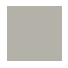

#769eca


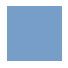

#333429


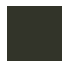

#6f853d


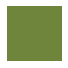

#f1f2f0


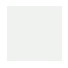

#d6d0c1


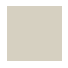

#7c7c71


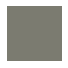

#acc9e4


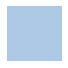

#97968b


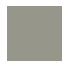

(6144000,)


In [17]:
palette8, kmeans8_labels = kmeansN(8)
print(kmeans8_labels.shape)

palette16, kmeans16_labels = kmeansN(16)
print(kmeans16_labels.shape)

# can't run 32 
# palette32, kmeans32_labels = kmeansN(32)
# print(kmeans32_labels.shape)

In [20]:
#palette24, kmeans24_labels = kmeansN(24)

In [21]:
k8_hot_encoding = tf.keras.utils.to_categorical([0, 1, 2, 3, 4, 5, 6, 7], num_classes=8)
y_encoded8 = []
for i in range(len(kmeans8_labels)):
  y_encoded8.append(k8_hot_encoding[kmeans8_labels[i]])

y_encoded8 = np.array(y_encoded8)

y_encoded8 = y_encoded8.reshape((-1,32, 32, 8))
print(y_encoded8.shape)
#print()

(6000, 32, 32, 8)


In [22]:
# using 5*5 filters and a softmax output layer
gray_bird_image = gray_bird_image.reshape((6000, 32, 32, 1))
train_gray_bird = gray_bird_image[:5000]
test_gray_bird = gray_bird_image[5000:]

def make_cnn_model8(image_size, class_size = 8, extra_layer=0):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
  #model.add(layers.MaxPooling2D((2, 2)))
  # Extra Layers

  # reshaping the output - 4 default class for k=4
  model.add(layers.Flatten())
  model.add(layers.Dense(16384, activation='relu'))
  model.add(layers.Dense(8192, activation='relu'))
  model.add(layers.Reshape((32,32,8)))
  model.add(layers.Softmax())
  #model.add(layers.Dense(32, activation='relu'))
  
  #model.add(layers.Dense(class_size))

  model.summary()

  return model

model8 = make_cnn_model8(32, class_size=8)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              134225920 
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 8)        

In [24]:
# compile and train
model8.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history8 = model8.fit(train_gray_bird, y_encoded8[:5000], epochs=10, 
                    validation_data=(test_gray_bird, y_encoded8[5000:]))

Epoch 1/10
157/157 [==============================] - 305s 2s/step - loss: 1.7503 - accuracy: 0.3367 - val_loss: 1.7725 - val_accuracy: 0.3267
Epoch 2/10
157/157 [==============================] - 300s 2s/step - loss: 1.7030 - accuracy: 0.3559 - val_loss: 1.7571 - val_accuracy: 0.3365
Epoch 3/10
157/157 [==============================] - 298s 2s/step - loss: 1.6675 - accuracy: 0.3704 - val_loss: 1.7379 - val_accuracy: 0.3417
Epoch 4/10
157/157 [==============================] - 296s 2s/step - loss: 1.6256 - accuracy: 0.3873 - val_loss: 1.7370 - val_accuracy: 0.3461
Epoch 5/10
157/157 [==============================] - 296s 2s/step - loss: 1.5720 - accuracy: 0.4069 - val_loss: 1.7239 - val_accuracy: 0.3518
Epoch 6/10
157/157 [==============================] - 296s 2s/step - loss: 1.5169 - accuracy: 0.4248 - val_loss: 1.7210 - val_accuracy: 0.3510
Epoch 7/10
157/157 [==============================] - 300s 2s/step - loss: 1.4567 - accuracy: 0.4445 - val_loss: 1.7414 - val_accuracy: 0.3533

32/32 [==============================] - 7s 207ms/step - loss: 1.8609 - accuracy: 0.3449
(1000, 32, 32, 8)


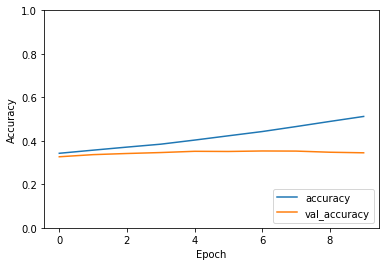

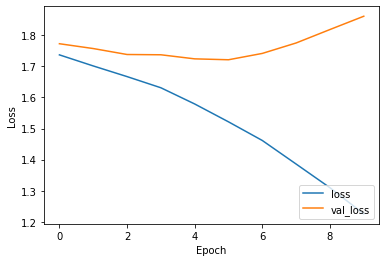

Test_result: 
test accuracy for kmeans = 8:  0.3449101448059082
test loss for kmeans = 8:  1.860893726348877


In [25]:
test_loss8, test_acc8 = model8.evaluate(test_gray_bird, y_encoded8[5000:], verbose=1)
# predict
pred_test8 = model8.predict(test_gray_bird)
print(pred_test8.shape)

plt.plot(history8.history['accuracy'], label='accuracy')
plt.plot(history8.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# prediction[i] = clusters_center_[prediction[i]]
plt.show()

plt.plot(history8.history['loss'], label='loss')
plt.plot(history8.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

print("Test_result: ")
print("test accuracy for kmeans = 8: ", test_acc8)
print("test loss for kmeans = 8: ", test_loss8)

p_t_shape:  (1000, 1024, 8)
K8_color_pixels (1000, 32, 32, 3)


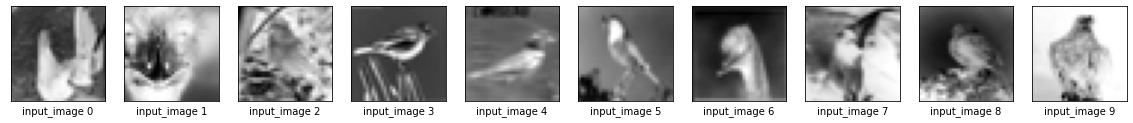

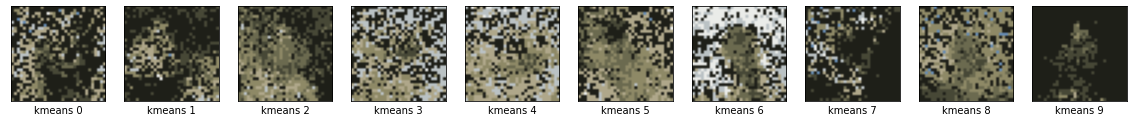

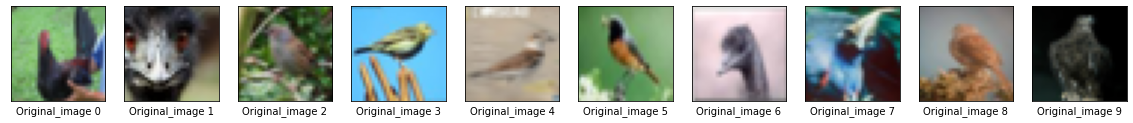

In [28]:
pred_test8 = pred_test8.reshape((-1, 1024, 8))
print("p_t_shape: ", pred_test8.shape)
# argmax returns the indices of the maximum value along an axis
pred8_labels = np.argmax(pred_test8, axis=2)
k8_color_pixels = []
for x in pred8_labels:
  k8_color_pixels.append(palette8[x])
k8_color_pixels = np.array(k8_color_pixels)
k8_color_pixels = k8_color_pixels.reshape((1000, 32, 32,3))
print("K8_color_pixels", k8_color_pixels.shape)
# print(k_color_pixels[:3])

numbers = []
for i in range(10):
  numbers.append(i)

plot10Images(k8_color_pixels, gray_bird_image_cp, bird_test_images, numbers)

In [29]:
# k = 16
k16_hot_encoding = tf.keras.utils.to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], num_classes=16)
y_encoded16 = []
for i in range(len(kmeans16_labels)):
  y_encoded16.append(k16_hot_encoding[kmeans16_labels[i]])

y_encoded16 = np.array(y_encoded16)

y_encoded16 = y_encoded16.reshape((-1,32, 32, 16))
print(y_encoded16.shape)
#print()

(6000, 32, 32, 16)


In [31]:
# using 5*5 filters and a softmax output layer
gray_bird_image = gray_bird_image.reshape((6000, 32, 32, 1))
train_gray_bird = gray_bird_image[:5000]
test_gray_bird = gray_bird_image[5000:]

def make_cnn_model16(image_size, class_size = 16, extra_layer=0):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
  #model.add(layers.MaxPooling2D((2, 2)))
  # Extra Layers

  # reshaping the output - 4 default class for k=4
  model.add(layers.Flatten())
  model.add(layers.Dense(16384, activation='relu'))
  # model.add(layers.Dense(8192, activation='relu'))
  model.add(layers.Reshape((32,32,16)))
  model.add(layers.Softmax())
  #model.add(layers.Dense(32, activation='relu'))
  
  #model.add(layers.Dense(class_size))

  model.summary()

  return model

model16 = make_cnn_model16(32, class_size=16)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
reshape_3 (Reshape)          (None, 32, 32, 16)        0         
_________________________________________________________________
softmax_3 (Softmax)          (None, 32, 32, 16)       

In [ ]:
model16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history16 = model16.fit(train_gray_bird, y_encoded16[:5000], epochs=10, 
                    validation_data=(test_gray_bird, y_encoded16[5000:]))

Epoch 1/10
157/157 [==============================] - 84s 531ms/step - loss: 2.7375 - accuracy: 0.1071 - val_loss: 2.6632 - val_accuracy: 0.1526
Epoch 2/10
157/157 [==============================] - 83s 530ms/step - loss: 2.6172 - accuracy: 0.1729 - val_loss: 2.5863 - val_accuracy: 0.1809
Epoch 3/10
157/157 [==============================] - 84s 537ms/step - loss: 2.5567 - accuracy: 0.1959 - val_loss: 2.5601 - val_accuracy: 0.1923
Epoch 4/10
157/157 [==============================] - 84s 532ms/step - loss: 2.5193 - accuracy: 0.2126 - val_loss: 2.5345 - val_accuracy: 0.2018
Epoch 5/10
157/157 [==============================] - 84s 533ms/step - loss: 2.4844 - accuracy: 0.2273 - val_loss: 2.5225 - val_accuracy: 0.2079
Epoch 6/10
157/157 [==============================] - 84s 537ms/step - loss: 2.4587 - accuracy: 0.2377 - val_loss: 2.5046 - val_accuracy: 0.2144
Epoch 7/10
157/157 [==============================] - 84s 537ms/step - loss: 2.4254 - accuracy: 0.2498 - val_loss: 2.5013 - val_ac

In [ ]:
test_loss16, test_acc16 = model16.evaluate(test_gray_bird, y_encoded16[5000:], verbose=1)
# predict
pred16_test = model16.predict(test_gray_bird)
print(pred16_test.shape)

plt.plot(history16.history['accuracy'], label='accuracy')
plt.plot(history16.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# prediction[i] = clusters_center_[prediction[i]]
plt.show()

plt.plot(history16.history['loss'], label='loss')
plt.plot(history16.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

print("Test_result: ")
print("test accuracy for kmeans = 8: ", test_acc16)
print("test loss for kmeans = 8: ", test_loss16)

pred16_test = pred16_test.reshape((-1, 1024, 16))
print("p_t_shape: ", pred16_test.shape)
# argmax returns the indices of the maximum value along an axis
pred16_labels = np.argmax(pred116_test, axis=2)
k16_color_pixels = []
for x in pred16_labels:
  k16_color_pixels.append(palette16[x])
k16_color_pixels = np.array(k16_color_pixels)
k16_color_pixels = k16_color_pixels.reshape((1000, 32, 32,3))
print("K16_color_pixels", k16_color_pixels.shape)
# print(k_color_pixels[:3])

numbers = []
for i in range(10):
  numbers.append(i)

plot10Images(k16_color_pixels, gray_bird_image_cp, bird_test_images, numbers)